GOOG & AAPL

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [180]:
class TradingStrategyAnalyzer:
    def __init__(self):
        pass

    def performance(self, x, ntrades=1, cost=0):
        """
        Calculates the performance of a stock or portfolio given the returns data.
        
        Parameters:
        x (pd.Series): an array containing the daily returns of the stock or portfolio.
        ntrades (int, optional): the number of trades. Default is 1.
        cost (float, optional): the transaction cost for each trade. Default is 0.
        
        Returns:
        Series: A pandas Series object containing the performance statistics of the stock or portfolio. 
        The Series object has the following indices:
            - Cumulative Return
            - Annual Return
            - Annualized Sharpe Ratio
            - Win %
            - Annualized Volatility
            - Maximum Drawdown
            - Max Length Drawdown
            - n.trades
        """ 
        cumRetx = np.cumsum(x, axis=0) - ntrades * cost
        annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
        sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
        winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
        annSDx = np.std(x, ddof=1) * np.sqrt(252)

        DDs = np.minimum.accumulate(cumRetx) - cumRetx
        maxDDx = DDs.min()
        maxLx = (cumRetx == DDs).argmax()

        Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
        names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
        "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
        return pd.Series(Perf, index=names, name=x.name)

    def test_MA_strategy(self, myStock, ts=None, s=5, m=20, longshort=0, tcost=0):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        myStock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0. for short use -1
        tcost (float, optional): the transaction cost for each trade. Default is 0.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = myStock

        sig = pd.Series(np.where(
            pd.Series(ts).rolling(s).mean() > pd.Series(ts).rolling(m).mean(), 1, longshort
            )).shift(1)
        sig.index = ts.index

        bmkReturns = (myStock / myStock.shift(1) - 1).dropna()
        myReturns = bmkReturns * sig
        myReturns.name = "MAx"
        bmkReturns.name = "BH"

        tt = pd.concat([myReturns, bmkReturns], axis=1).dropna()

        lruns = np.count_nonzero(np.diff(sig)) + 1
        bhPerf = self.performance(tt.BH, 2, tcost)
        maxPerf = self.performance(tt.MAx, lruns, tcost)

        plt.figure(figsize=(12, 6))
        plt.plot(np.cumsum(tt.MAx, axis=0), label="MAx")
        plt.plot(np.cumsum(tt.BH, axis=0), label="BH")
        plt.legend()
        plt.show()

        return pd.concat([maxPerf, bhPerf], axis=1)

    def rolling_test_MA_strategy(self, my_stock, ts=None, s=5, m=20, longshort=0, w_size=252):
        """
        Calculates the performance of a moving average crossover strategy.

        Parameters:
        my_stock (ndarray): an array containing the daily returns of the stock.
        ts (ndarray, optional): an array containing the daily returns of the stock. Default is None.
        s (int, optional): the short window. Default is 5.
        m (int, optional): the long window. Default is 20.
        longshort (int, optional): the long/short strategy. Default is 0.
        w_size (int, optional): the window size. Default is 252.

        Returns:
        DataFrame: A pandas DataFrame object containing the performance statistics of the strategy and the benchmark.
        The DataFrame object has the following columns:
            - MAx: the performance statistics of the strategy.
            - BH: the performance statistics of the benchmark.
        """
        if ts is None:
            ts = my_stock

        sig = (pd.Series(np.where(ts.rolling(window=s).mean() > ts.rolling(window=m).mean(), 1, longshort), name='sig')
                .shift(1))
        sig.index = ts.index

        bmk_returns = (my_stock / my_stock.shift(1) - 1).rename("BH")
        my_returns = bmk_returns * sig
        my_returns.rename("Me", inplace=True)
        tt = pd.concat([bmk_returns, my_returns], axis=1).dropna()
        n_windows = int(tt.shape[0] - w_size)
        if n_windows < 1:
            raise ValueError("Window size too large")
        
        perform = []
        for i in range(n_windows):
            bh_stra = tt.iloc[i:w_size+i, 0]
            my_stra = tt.iloc[i:w_size+i, 1]
            perform.append([bh_stra.mean(), my_stra.mean()])
        perform = np.array(perform)
        
        bh_means = perform[:,0].mean()
        me_means = perform[:,1].mean()
        mean_perf = np.array([bh_means, me_means])
        mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
        
        return {"AvgPerf": mean_perf, "NumWindows": n_windows}

In [181]:
# tau=1 # because the data is daily
# goog = pd.read_csv('GOOG.csv', sep = ',')
# goog = goog.iloc[:, 1:] # removing the first column (unnamed)
# aapl = pd.read_csv('aapl.csv', sep = ',')
# aapl = aapl.iloc[:, 1:]

# print(goog.head())
# print(aapl.head())

In [182]:
tau=1 # because the data is daily
goog = pd.read_csv('dataSent/GOOG.csv', sep = ',')
goog = goog.iloc[:, 1:] # removing the first column (unnamed)
aapl = pd.read_csv('dataSent/aapl.csv', sep = ',')
aapl = aapl.iloc[:, 1:]

print(goog.head())
print(aapl.head())

         Date         Open         High          Low        Close  \
0  2018-01-02  1048.339966  1066.939941  1045.229980  1065.000000   
1  2018-01-03  1064.310059  1086.290039  1063.209961  1082.479980   
2  2018-01-04  1088.000000  1093.569946  1084.001953  1086.400024   
3  2018-01-05  1094.000000  1104.250000  1092.000000  1102.229980   
4  2018-01-08  1102.229980  1111.270020  1101.619995  1106.939941   

     Adj Close   Volume     RVT  positivePartscr  negativePartscr  \
0  1065.000000  1237600  0.0009           0.0169           0.0169   
1  1082.479980  1430200  0.0006           0.0165           0.0180   
2  1086.400024  1004600  0.0014           0.0071           0.0231   
3  1102.229980  1279100  0.0015           0.0062           0.0403   
4  1106.939941  1047600  0.0016           0.0109           0.0160   

   fearPartscr  findownPartscr  finupPartscr  finhypePartscr  \
0       0.0018          0.0073        0.0369          0.0093   
1       0.0007          0.0079        0.02

In [183]:
df_goog = pd.DataFrame(goog.values[:, 1:], index=pd.to_datetime(goog.values[:, 0]), columns=goog.columns[1:])
df_aapl = pd.DataFrame(aapl.values[:, 1:], index=pd.to_datetime(aapl.values[:, 0]), columns=aapl.columns[1:])

In [184]:
# transform all columns to float
df_goog = df_goog.astype(float)
df_aapl = df_aapl.astype(float)

In [185]:
## Target :  Adj Close Price 
target_goog = df_goog['Adj Close']
target_aapl = df_aapl['Adj Close']

target_goog.name = "GOOG"
target_aapl.name = "GOOG"

print(target_goog.head())
print(target_aapl.head())

2018-01-02    1065.000000
2018-01-03    1082.479980
2018-01-04    1086.400024
2018-01-05    1102.229980
2018-01-08    1106.939941
Name: GOOG, dtype: float64
2018-01-02    166.353714
2018-01-03    166.324722
2018-01-04    167.097290
2018-01-05    168.999741
2018-01-08    168.372040
Name: GOOG, dtype: float64


Indicators

In [186]:
# Para GOOG
negativeP_goog = df_goog['negativePartscr'].dropna()
negativeP_goog.name = "negative"
uncertaintyP_goog = df_goog['uncertaintyPartscr'].dropna()
findownP_goog = df_goog['findownPartscr'].dropna()

positiveP_goog = df_goog['positivePartscr'].dropna()
positiveP_goog.name = "positive"
certaintyP_goog = df_goog['certaintyPartscr'].dropna()
finupP_goog = df_goog['finupPartscr'].dropna()

BULL_goog = 0.33 * (positiveP_goog + certaintyP_goog + finupP_goog)
BEAR_goog = 0.33 * (negativeP_goog + uncertaintyP_goog + findownP_goog)
BULL_goog.name = "BULL"
BEAR_goog.name = "BEAR"

display(BULL_goog.head())
display(BEAR_goog.head())

# Para aapl
negativeP_aapl = df_aapl['negativePartscr'].dropna()
negativeP_aapl.name = "negative"
uncertaintyP_aapl = df_aapl['uncertaintyPartscr'].dropna()
findownP_aapl = df_aapl['findownPartscr'].dropna()

positiveP_aapl = df_aapl['positivePartscr'].dropna()
positiveP_aapl.name = "positive"
certaintyP_aapl = df_aapl['certaintyPartscr'].dropna()
finupP_aapl = df_aapl['finupPartscr'].dropna()

BULL_aapl = 0.33 * (positiveP_aapl + certaintyP_aapl + finupP_aapl)
BEAR_aapl = 0.33 * (negativeP_aapl + uncertaintyP_aapl + findownP_aapl)
BULL_aapl.name = "BULL"
BEAR_aapl.name = "BEAR"

display(BULL_aapl.head())
display(BEAR_aapl.head())

2018-01-02    0.022275
2018-01-03    0.018744
2018-01-04    0.009966
2018-01-05    0.007524
2018-01-08    0.008217
Name: BULL, dtype: float64

2018-01-02    0.009702
2018-01-03    0.010428
2018-01-04    0.012771
2018-01-05    0.019305
2018-01-08    0.007986
Name: BEAR, dtype: float64

2018-01-02    0.018315
2018-01-03    0.019734
2018-01-04    0.012408
2018-01-05    0.011814
2018-01-08    0.016566
Name: BULL, dtype: float64

2018-01-02    0.011451
2018-01-03    0.011880
2018-01-04    0.013167
2018-01-05    0.020427
2018-01-08    0.011418
Name: BEAR, dtype: float64

**PNlog**: Measures the balance between negative and positive sentiment. 

In [187]:
# Para GOOG
PNlog_goog = 0.5 * np.log((positiveP_goog + 1) / (negativeP_goog + 1))
PNlog_goog.name = "PNlog_GOOG"
display(PNlog_goog.head())

# Para aapl
PNlog_aapl = 0.5 * np.log((positiveP_aapl + 1) / (negativeP_aapl + 1))
PNlog_aapl.name = "PNlog_aapl"
display(PNlog_aapl.head())

2018-01-02    0.000000
2018-01-03   -0.000737
2018-01-04   -0.007881
2018-01-05   -0.016664
2018-01-08   -0.002516
Name: PNlog_GOOG, dtype: float64

2018-01-02    0.002215
2018-01-03   -0.001082
2018-01-04   -0.006521
2018-01-05   -0.015344
2018-01-08    0.000294
Name: PNlog_aapl, dtype: float64

In [188]:
# Para GOOG
BULL_BEAR_goog = BULL_goog + BEAR_goog
BULL_BEAR_goog[BULL_BEAR_goog == 0] = np.nan  # Evitar división por cero
BBr_goog = 100 * BULL_goog / BULL_BEAR_goog
BBr_goog.fillna(method='ffill', inplace=True)
BBr_goog.fillna(method='bfill', inplace=True)
BBr_goog.name = "BBr_GOOG"

display(BBr_goog.head())

# Para aapl
BULL_BEAR_aapl = BULL_aapl + BEAR_aapl
BULL_BEAR_aapl[BULL_BEAR_aapl == 0] = np.nan  # Evitar división por cero
BBr_aapl = 100 * BULL_aapl / BULL_BEAR_aapl
BBr_aapl.fillna(method='ffill', inplace=True)
BBr_aapl.fillna(method='bfill', inplace=True)
BBr_aapl.name = "BBr_aapl"

display(BBr_aapl.head())

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/420396643.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='ffill', inplace=True)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/420396643.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_goog.fillna(method='bfill', inplace=True)


2018-01-02    69.659443
2018-01-03    64.253394
2018-01-04    43.831640
2018-01-05    28.044280
2018-01-08    50.712831
Name: BBr_GOOG, dtype: float64

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/420396643.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_aapl.fillna(method='ffill', inplace=True)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/420396643.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BBr_aapl.fillna(method='bfill', inplace=True)


2018-01-02    61.529933
2018-01-03    62.421712
2018-01-04    48.516129
2018-01-05    36.642784
2018-01-08    59.198113
Name: BBr_aapl, dtype: float64

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

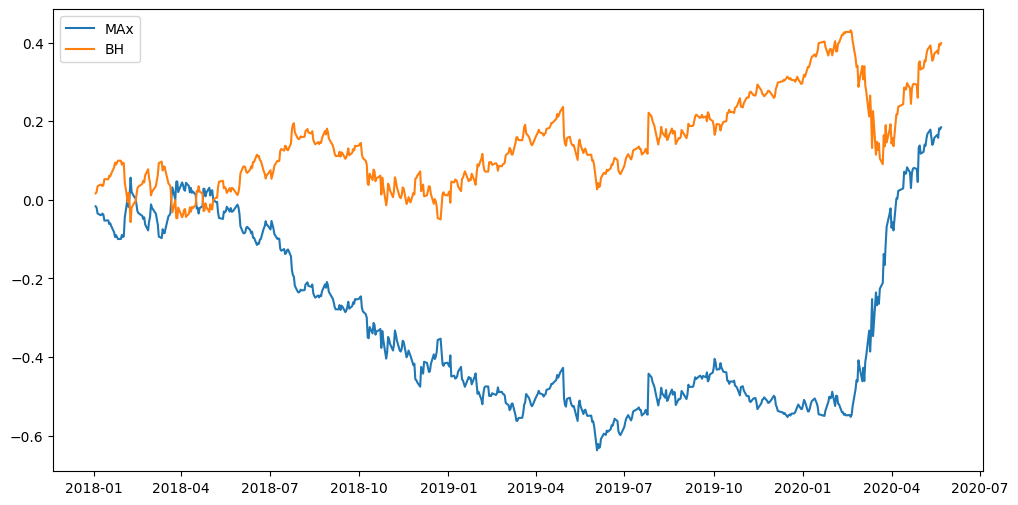

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.765409,0.298745
Annual Return,-0.455534,0.115837
Annualized Sharpe Ratio,-365.129032,92.888930
Win %,0.497504,0.535774
Annualized Volatility,0.314395,0.314256
Maximum Drawdown,-0.821610,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,19.000000,2.000000


In [189]:
# Para GOOG
target = target_goog  # Serie de precios objetivo
BEAR_var = BEAR_goog  # Puedes cambiar por BULL_goog, BBr_goog, PNlog_goog, etc.

# Ejecutar la estrategia usando la clase
analyzer = TradingStrategyAnalyzer()
res_goog = analyzer.test_MA_strategy(target, BEAR_var, s=30, m=100, longshort=-1, tcost=0.05)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

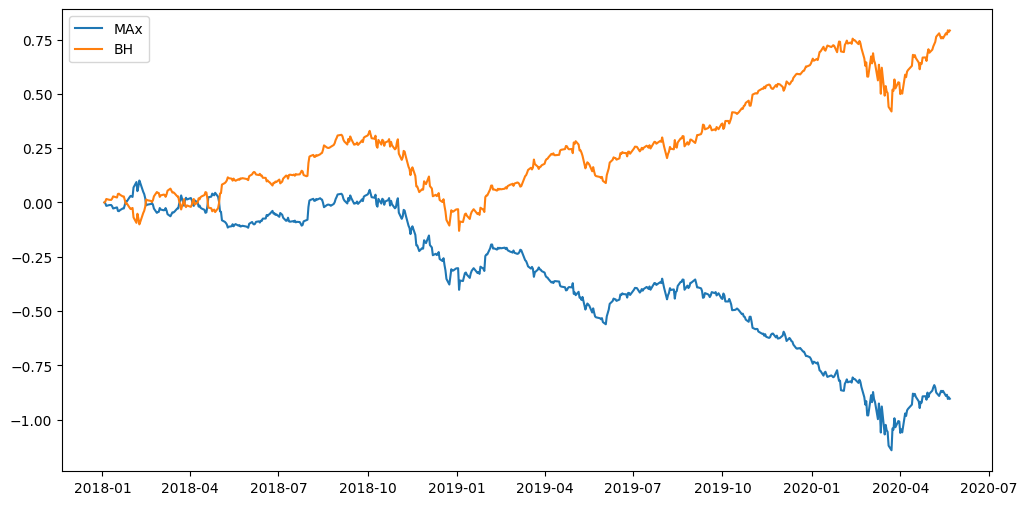

Resultados para aapl:


,MAx,BH
Cumulative Return,-1.803690,0.691569
Annual Return,NaN,0.246586
Annualized Sharpe Ratio,NaN,181.210185
Win %,0.470882,0.540765
Annualized Volatility,0.342721,0.342915
Maximum Drawdown,-0.300031,-0.923330
Max Length Drawdown,0.000000,0.000000
n.trades,18.000000,2.000000


In [190]:
# Para aapl
target = target_aapl
BEAR_var = BEAR_aapl  # O el indicador que quieras probar

res_aapl = analyzer.test_MA_strategy(target, BEAR_var, s=30, m=100, longshort=-1, tcost=0.05)
print("Resultados para aapl:")
display(res_aapl)

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

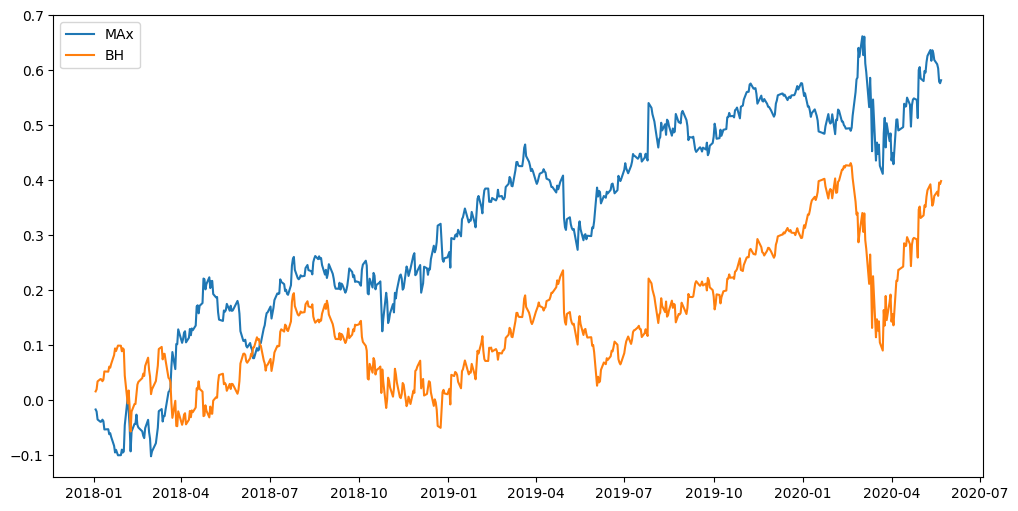

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.307980,0.378745
Annual Return,-0.143038,0.144157
Annualized Sharpe Ratio,-114.774294,115.599053
Win %,0.527454,0.535774
Annualized Volatility,0.314056,0.314256
Maximum Drawdown,-0.763415,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,89.000000,2.000000


In [191]:
analyzer = TradingStrategyAnalyzer()

# Elige el target y el explanatory variable (puedes cambiar BEAR_goog por BULL_goog, BBr_goog, etc.)
target = target_goog
ev = BEAR_goog

res_goog = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=-1, tcost=0.01)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

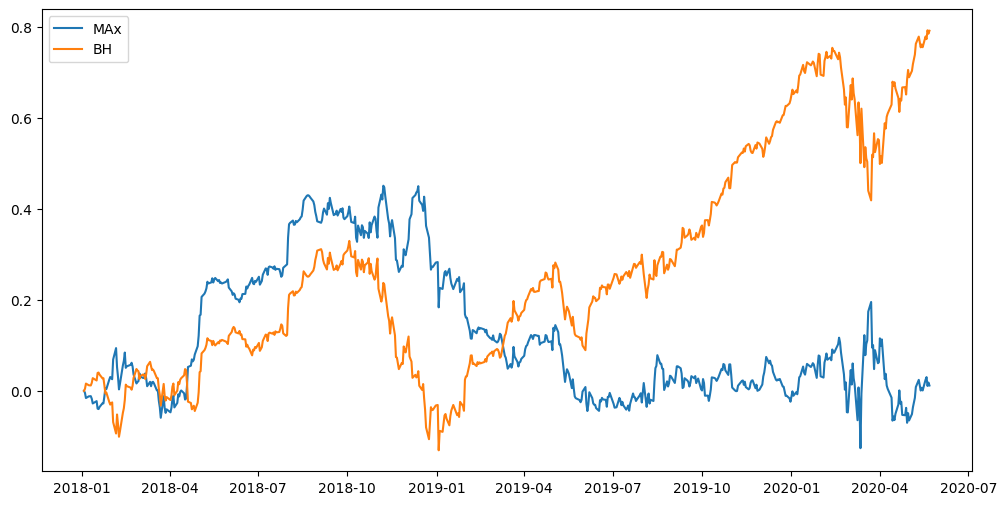

Resultados para aapl:


,MAx,BH
Cumulative Return,-0.668323,0.771569
Annual Return,-0.370442,0.270975
Annualized Sharpe Ratio,-271.724053,199.132918
Win %,0.504160,0.540765
Annualized Volatility,0.343552,0.342915
Maximum Drawdown,-0.510197,-0.923330
Max Length Drawdown,0.000000,0.000000
n.trades,68.000000,2.000000


In [192]:
analyzer = TradingStrategyAnalyzer()

target = target_aapl
ev = BEAR_aapl

res_aapl = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=-1, tcost=0.01)
print("Resultados para aapl:")
display(res_aapl)

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

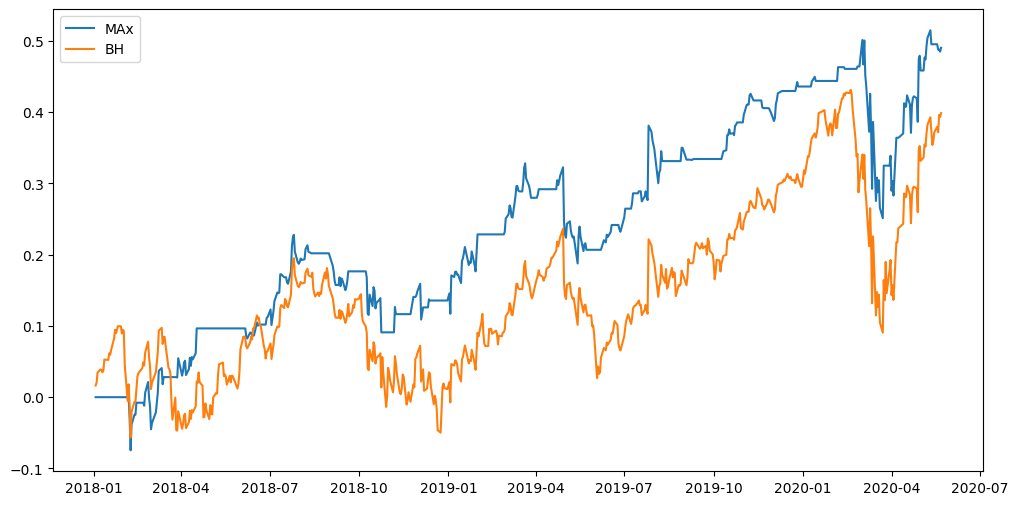

Resultados para GOOG:


,MAx,BH
Cumulative Return,-0.399617,0.378745
Annual Return,-0.192589,0.144157
Annualized Sharpe Ratio,-192.681993,115.599053
Win %,0.565068,0.535774
Annualized Volatility,0.251878,0.314256
Maximum Drawdown,-0.589415,-0.487803
Max Length Drawdown,0.000000,0.000000
n.trades,89.000000,2.000000


In [193]:
analyzer = TradingStrategyAnalyzer()

# Elige el target y el explanatory variable (puedes cambiar BEAR_goog por otro indicador)
target = target_goog
ev = BEAR_goog

res_goog = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=0, tcost=0.01)
print("Resultados para GOOG:")
display(res_goog)

/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

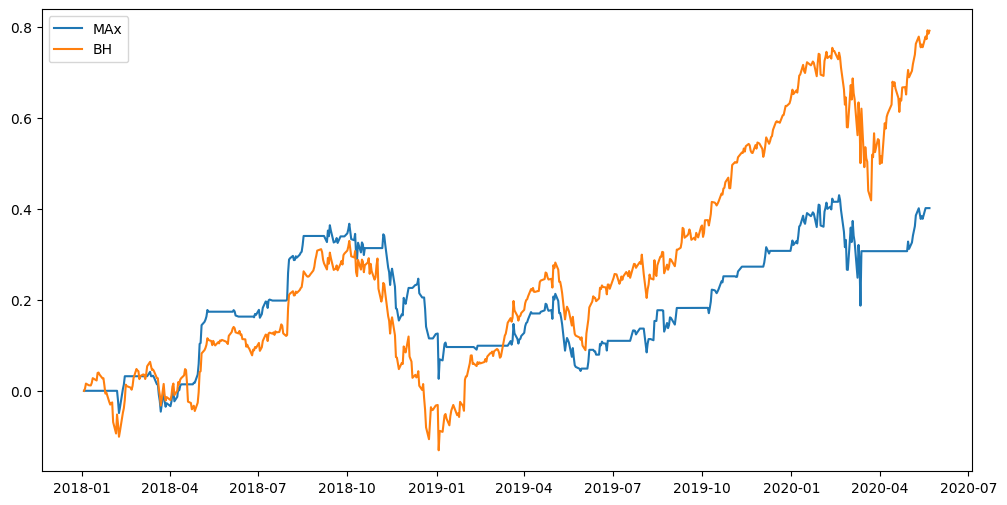

Resultados para aapl:


,MAx,BH
Cumulative Return,-0.278377,0.771569
Annual Return,-0.127853,0.270975
Annualized Sharpe Ratio,-124.650278,199.132918
Win %,0.545151,0.540765
Annualized Volatility,0.258476,0.342915
Maximum Drawdown,-0.478998,-0.923330
Max Length Drawdown,0.000000,0.000000
n.trades,68.000000,2.000000


In [194]:
analyzer = TradingStrategyAnalyzer()

target = target_aapl
ev = BEAR_aapl

res_aapl = analyzer.test_MA_strategy(target, ev, s=10, m=25, longshort=0, tcost=0.01)
print("Resultados para aapl:")
display(res_aapl)

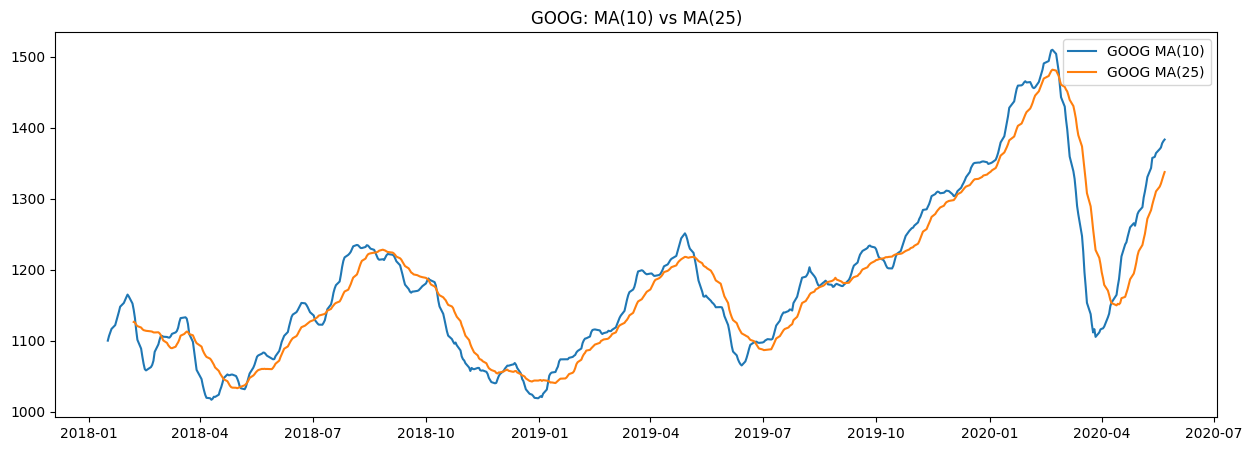

In [195]:
plt.figure(figsize=(15, 5))
plt.plot(target_goog.index, target_goog.rolling(window=10).mean(), label='GOOG MA(10)')
plt.plot(target_goog.index, target_goog.rolling(window=25).mean(), label='GOOG MA(25)')
# Si quieres también puedes mostrar el precio:
# plt.plot(target_goog.index, target_goog, label='GOOG Price', alpha=0.5)
plt.legend(loc='best')
plt.title('GOOG: MA(10) vs MA(25)')
plt.show()

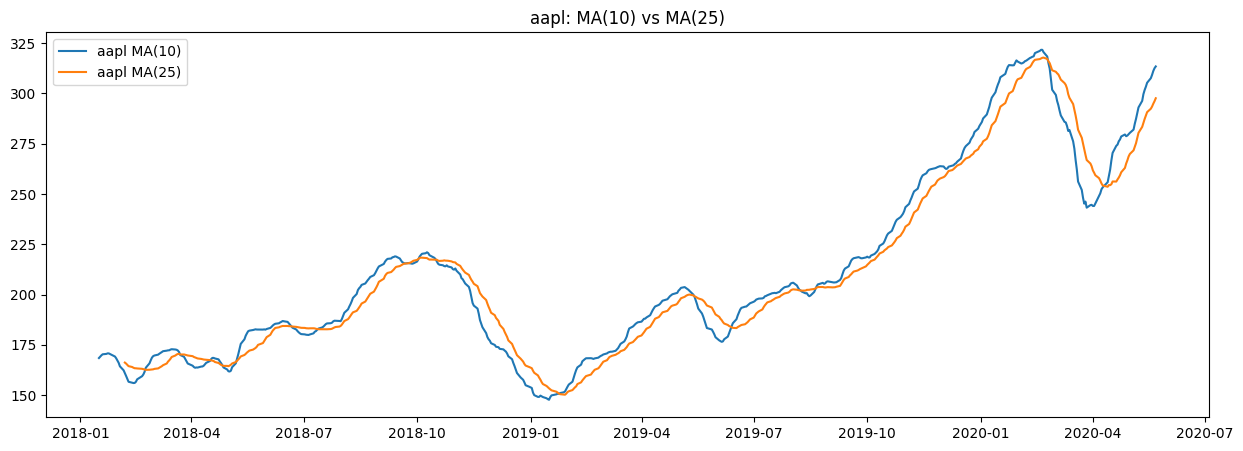

In [196]:
plt.figure(figsize=(15, 5))
plt.plot(target_aapl.index, target_aapl.rolling(window=10).mean(), label='aapl MA(10)')
plt.plot(target_aapl.index, target_aapl.rolling(window=25).mean(), label='aapl MA(25)')
# Si quieres también puedes mostrar el precio:
# plt.plot(target_aapl.index, target_aapl, label='aapl Price', alpha=0.5)
plt.legend(loc='best')
plt.title('aapl: MA(10) vs MA(25)')
plt.show()

In [197]:
analyzer = TradingStrategyAnalyzer()

# Puedes cambiar ev_goog por el indicador que quieras (por ejemplo, BULL_goog, BBr_goog, etc.)
target = target_goog
ev_goog = BEAR_goog

manperf_goog = analyzer.rolling_test_MA_strategy(target, ev_goog, s=10, m=25, longshort=-1, w_size=252//2)
print("Average Performance (GOOG):")
print(manperf_goog)

Average Performance (GOOG):
{'AvgPerf':      AvgPerf
BH  0.000570
Me  0.001008, 'NumWindows': 475}


In [198]:
analyzer = TradingStrategyAnalyzer()

target = target_aapl
ev_aapl = BEAR_aapl

manperf_aapl = analyzer.rolling_test_MA_strategy(target, ev_aapl, s=10, m=25, longshort=-1, w_size=252//2)
print("Average Performance (aapl):")
print(manperf_aapl)

Average Performance (aapl):
{'AvgPerf':      AvgPerf
BH  0.001268
Me -0.000122, 'NumWindows': 475}


## Momentum Strategy

In [199]:
# Parameters
momentum_window = 3  # You can tune this parameter

# GOOG
momentum_goog = PNlog_goog.diff(momentum_window)
signal_momentum_goog = (momentum_goog > 0).astype(int)  # 1 if momentum positive, 0 otherwise

# aapl
momentum_aapl = PNlog_aapl.diff(momentum_window)
signal_momentum_aapl = (momentum_aapl > 0).astype(int)

### Choosing the best parameter combination for each ticker

In [200]:
### GOOG ###
indicators_goog = {
    'positiveP': positiveP_goog,
    'negativeP': negativeP_goog,
    'BULL': BULL_goog,
    'BEAR': BEAR_goog,
    'BBr': 100 * BULL_goog / (BULL_goog + BEAR_goog),  # BBr according to the formula
    'PNlog': PNlog_goog
}

momentum_window = 3
results = {}

# Test each indicator individually
for name, series in indicators_goog.items():
    momentum = series.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # You can add the RVT filter if you want:
    # news_filter = (df_goog['RVT'].loc[signal.index] > df_goog['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_goog / target_goog.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name,)] = perf['Cumulative Return']

# Test all combinations of two indicators (simple average)
for (name1, series1), (name2, series2) in itertools.combinations(indicators_goog.items(), 2):
    combined = (series1 + series2) / 2
    momentum = combined.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # news_filter = (df_goog['RVT'].loc[signal.index] > df_goog['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_goog / target_goog.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name1, name2)] = perf['Cumulative Return']

# Find the best combination
best_combo = max(results, key=results.get)
print("The best combination of indicators is:", best_combo)
print("Cumulative Return:", results[best_combo])

# If you want to see all results sorted:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nRanking of combinations (from best to worst):")
for combo, score in sorted_results:
    print(combo, "->", score)

The best combination of indicators is: ('BBr',)
Cumulative Return: 0.9797066364802427

Ranking of combinations (from best to worst):
('BBr',) -> 0.9797066364802427
('positiveP', 'BBr') -> 0.9797066364802427
('negativeP', 'BBr') -> 0.9797066364802427
('BULL', 'BBr') -> 0.9797066364802427
('BEAR', 'BBr') -> 0.9797066364802427
('BBr', 'PNlog') -> 0.9797066364802427
('PNlog',) -> 0.6757632645051982
('BULL',) -> 0.5273696169643977
('positiveP', 'BULL') -> 0.3903835590722887
('BEAR', 'PNlog') -> 0.34715880860323356
('positiveP', 'PNlog') -> 0.3265278757578006
('positiveP',) -> 0.31588665395427407
('BULL', 'PNlog') -> 0.2761464850425003
('BULL', 'BEAR') -> 0.18288068345862274
('positiveP', 'BEAR') -> 0.10846549102414726
('BEAR',) -> 0.04457962342458799
('negativeP',) -> 0.0413978104222571
('negativeP', 'BEAR') -> -0.05792873677129373
('negativeP', 'BULL') -> -0.09037315019405912
('positiveP', 'negativeP') -> -0.16450268474222518
('negativeP', 'PNlog') -> -0.20480176450983856


/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [201]:
### aapl ###
# Define the indicators to test
indicators_aapl = {
    'positiveP': positiveP_aapl,
    'negativeP': negativeP_aapl,
    'BULL': BULL_aapl,
    'BEAR': BEAR_aapl,
    'BBr': 100 * BULL_aapl / (BULL_aapl + BEAR_aapl),  # BBr according to the formula
    'PNlog': PNlog_aapl
}

momentum_window = 3
results = {}

# Test each indicator individually
for name, series in indicators_aapl.items():
    momentum = series.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # You can add the RVT filter if you want:
    # news_filter = (df_aapl['RVT'].loc[signal.index] > df_aapl['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_aapl / target_aapl.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name,)] = perf['Cumulative Return']

# Test all combinations of two indicators (simple average)
for (name1, series1), (name2, series2) in itertools.combinations(indicators_aapl.items(), 2):
    combined = (series1 + series2) / 2
    momentum = combined.diff(momentum_window)
    signal = (momentum > 0).astype(int)
    # news_filter = (df_aapl['RVT'].loc[signal.index] > df_aapl['RVT'].median()).astype(int)
    # signal = signal * news_filter
    returns = (target_aapl / target_aapl.shift(1) - 1).dropna()
    strategy_returns = returns * signal.shift(1)
    strategy_returns = strategy_returns.dropna()
    perf = analyzer.performance(strategy_returns)
    results[(name1, name2)] = perf['Cumulative Return']

# Find the best combination
best_combo = max(results, key=results.get)
print("The best combination of indicators is:", best_combo)
print("Cumulative Return:", results[best_combo])

# If you want to see all results sorted:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nRanking of combinations (from best to worst):")
for combo, score in sorted_results:
    print(combo, "->", score)

The best combination of indicators is: ('negativeP', 'BULL')
Cumulative Return: 0.9565788228840921

Ranking of combinations (from best to worst):
('negativeP', 'BULL') -> 0.9565788228840921
('negativeP', 'PNlog') -> 0.8996864484073759
('positiveP', 'negativeP') -> 0.8647560472005065
('negativeP',) -> 0.8539510933418468
('BULL', 'BEAR') -> 0.8075419962306694
('BEAR',) -> 0.7663005138272285
('negativeP', 'BEAR') -> 0.7479975490518816
('positiveP', 'BEAR') -> 0.6772039801608761
('BULL',) -> 0.5624233201427994
('positiveP', 'BULL') -> 0.522960731661843
('positiveP', 'PNlog') -> 0.35280839258048446
('PNlog',) -> 0.30479777871162783
('positiveP',) -> 0.30201089496610334
('BEAR', 'PNlog') -> 0.14504445161423374
('BBr',) -> 0.09767198982229763
('positiveP', 'BBr') -> 0.09767198982229763
('negativeP', 'BBr') -> 0.09767198982229763
('BULL', 'BBr') -> 0.09767198982229763
('BEAR', 'BBr') -> 0.09767198982229763
('BBr', 'PNlog') -> 0.09767198982229763
('BULL', 'PNlog') -> 0.08483657377720244


/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [202]:
# # GOOG
# news_volume_filter_goog = (df_goog['RVT'].loc[signal_momentum_goog.index] > df_goog['RVT'].median()).astype(int)
# filtered_signal_goog = signal_momentum_goog * news_volume_filter_goog

# # aapl
# news_volume_filter_aapl = (df_aapl['RVT'].loc[signal_momentum_aapl.index] > df_aapl['RVT'].median()).astype(int)
# filtered_signal_aapl = signal_momentum_aapl * news_volume_filter_aapl

In [203]:
# GOOG - Use the best combination: ('positiveP', 'BEAR')
combined_goog = (BBr_goog) 
momentum_goog = combined_goog.diff(momentum_window)
signal_momentum_goog = (momentum_goog > 0).astype(int)
returns_goog = (target_goog / target_goog.shift(1) - 1).dropna()
strategy_returns_momentum_goog = returns_goog * signal_momentum_goog.shift(1)
strategy_returns_momentum_goog = strategy_returns_momentum_goog.dropna()

# # aapl - Use the best combination found for aapl (replace ('positiveP', 'BEAR') if different)
# combined_aapl = (positiveP_aapl + BEAR_aapl) / 2
# momentum_aapl = combined_aapl.diff(momentum_window)
# signal_momentum_aapl = (momentum_aapl > 0).astype(int)
# returns_aapl = (target_aapl / target_aapl.shift(1) - 1).dropna()
# strategy_returns_momentum_aapl = returns_aapl * signal_momentum_aapl.shift(1)
# strategy_returns_momentum_aapl = strategy_returns_momentum_aapl.dropna()

# Strategy for apple 
combined_aapl = (negativeP_aapl + BULL_aapl) / 2
momentum_aapl = combined_aapl.diff(momentum_window)
signal_momentum_aapl = (momentum_aapl > 0).astype(int)
returns_aapl = (target_aapl / target_aapl.shift(1) - 1).dropna()
strategy_returns_momentum_aapl = returns_aapl * signal_momentum_aapl.shift(1)
strategy_returns_momentum_aapl = strategy_returns_momentum_aapl.dropna()

In [204]:
analyzer = TradingStrategyAnalyzer()

# GOOG
perf_momentum_goog = analyzer.performance(strategy_returns_momentum_goog)
print("Performance Momentum (GOOG):")
print(perf_momentum_goog)

# aapl
perf_momentum_aapl = analyzer.performance(strategy_returns_momentum_aapl)
print("Performance Momentum (AAPL):")
print(perf_momentum_aapl)

Performance Momentum (GOOG):
Cumulative Return            0.874588
Annual Return                0.301457
Annualized Sharpe Ratio    347.085717
Win %                        0.594059
Annualized Volatility        0.218871
Maximum Drawdown            -0.917829
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64
Performance Momentum (aapl):
Cumulative Return            0.956579
Annual Return                0.325028
Annualized Sharpe Ratio    367.534531
Win %                        0.580328
Annualized Volatility        0.222856
Maximum Drawdown            -0.988648
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64


/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

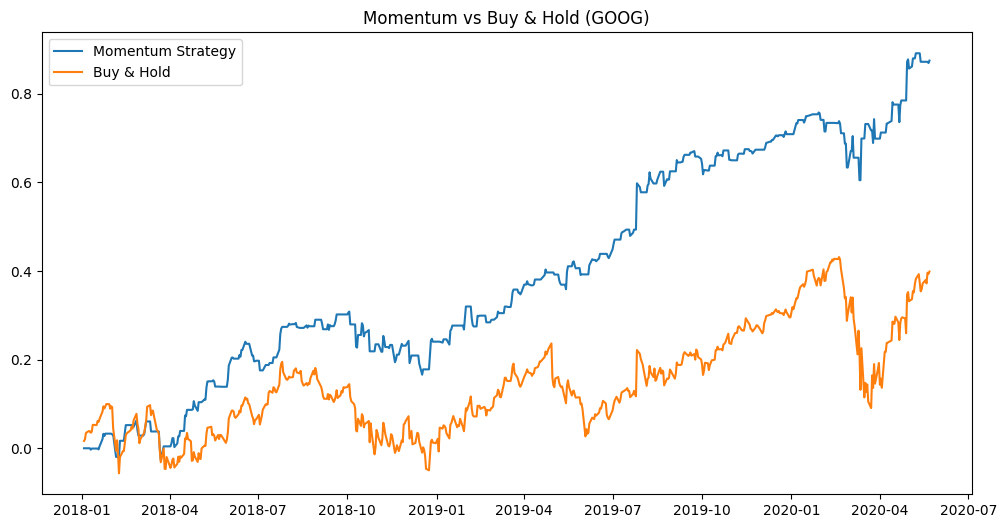

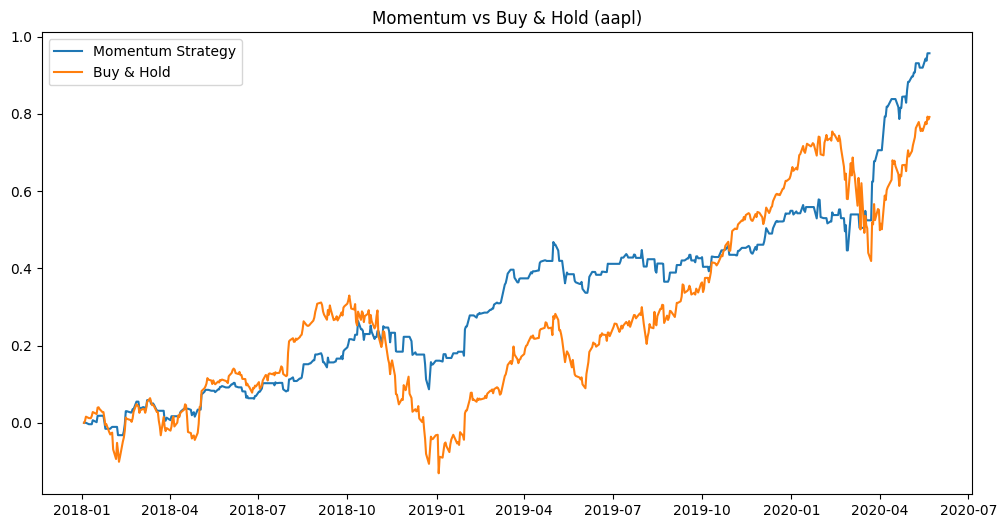

In [205]:
# GOOG
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_goog.cumsum(), label='Momentum Strategy')
plt.plot(returns_goog.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (GOOG)')
plt.show()

# aapl
plt.figure(figsize=(12,6))
plt.plot(strategy_returns_momentum_aapl.cumsum(), label='Momentum Strategy')
plt.plot(returns_aapl.cumsum(), label='Buy & Hold')
plt.legend()
plt.title('Momentum vs Buy & Hold (aapl)')
plt.show()

In [206]:
cost = 0.001  # 0.1% per trade

# GOOG
trades_goog = signal_momentum_goog.diff().abs().sum()
strategy_returns_momentum_goog_net = strategy_returns_momentum_goog - cost * trades_goog / len(strategy_returns_momentum_goog)
perf_momentum_goog_net = analyzer.performance(strategy_returns_momentum_goog_net)
print("Performance Momentum (GOOG) with transaction costs:")
print(perf_momentum_goog_net)

# aapl
trades_aapl = signal_momentum_aapl.diff().abs().sum()
strategy_returns_momentum_aapl_net = strategy_returns_momentum_aapl - cost * trades_aapl / len(strategy_returns_momentum_aapl)
perf_momentum_aapl_net = analyzer.performance(strategy_returns_momentum_aapl_net)
print("Performance Momentum (AAPL) with transaction costs:")
print(perf_momentum_aapl_net)

Performance Momentum (GOOG) with transaction costs:
Cumulative Return            0.633588
Annual Return                0.228488
Annualized Sharpe Ratio    263.072266
Win %                        0.292845
Annualized Volatility        0.218871
Maximum Drawdown            -0.703295
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64
Performance Momentum (aapl) with transaction costs:
Cumulative Return            0.692579
Annual Return                0.246898
Annualized Sharpe Ratio    279.186173
Win %                        0.286190
Annualized Volatility        0.222856
Maximum Drawdown            -0.737826
Max Length Drawdown          0.000000
n.trades                     1.000000
dtype: float64


/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/var/folders/11/n8r1kx5s21z1dc028c5lt_m40000gn/T/ipykernel_47690/2302811962.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

In [207]:
# Define signals for long-only and long-short
signal_long_only_goog = (momentum_goog > 0).astype(int)
signal_long_short_goog = pd.Series(np.where(momentum_goog > 0, 1, -1), index=momentum_goog.index)

signal_long_only_aapl = (momentum_aapl > 0).astype(int)
signal_long_short_aapl = pd.Series(np.where(momentum_aapl > 0, 1, -1), index=momentum_aapl.index)

window_size = 127  # 6 months

# GOOG
print(f"\nGOOG - Rolling window size: {window_size} days")
rolling_returns_long_only_goog = []
rolling_returns_long_short_goog = []
for start in range(len(returns_goog) - window_size + 1):
    end = start + window_size
    # Long-only
    window_returns_long_only = returns_goog.iloc[start:end] * signal_long_only_goog.shift(1).iloc[start:end]
    rolling_returns_long_only_goog.append(window_returns_long_only.sum())
    # Long-short
    window_returns_long_short = returns_goog.iloc[start:end] * signal_long_short_goog.shift(1).iloc[start:end]
    rolling_returns_long_short_goog.append(window_returns_long_short.sum())
print(f"Average rolling return (long-only): {np.mean(rolling_returns_long_only_goog)}")
print(f"Average rolling return (long-short): {np.mean(rolling_returns_long_short_goog)}")

# aapl
print(f"\naapl - Rolling window size: {window_size} days")
rolling_returns_long_only_aapl = []
rolling_returns_long_short_aapl = []
for start in range(len(returns_aapl) - window_size + 1):
    end = start + window_size
    # Long-only
    window_returns_long_only = returns_aapl.iloc[start:end] * signal_long_only_aapl.shift(1).iloc[start:end]
    rolling_returns_long_only_aapl.append(window_returns_long_only.sum())
    # Long-short
    window_returns_long_short = returns_aapl.iloc[start:end] * signal_long_short_aapl.shift(1).iloc[start:end]
    rolling_returns_long_short_aapl.append(window_returns_long_short.sum())
print(f"Average rolling return (long-only): {np.mean(rolling_returns_long_only_aapl)}")
print(f"Average rolling return (long-short): {np.mean(rolling_returns_long_short_aapl)}")


GOOG - Rolling window size: 127 days
Average rolling return (long-only): 0.1742405755005611
Average rolling return (long-short): 0.27660484998151985

aapl - Rolling window size: 127 days
Average rolling return (long-only): 0.15503797068899489
Average rolling return (long-short): 0.15032129974775682


In [209]:
import pandas as pd

# ... (your signal and rolling window code as before)

# Store results in a DataFrame
results = {
    "Ticker": ["GOOG", "GOOG", "AAPL", "AAPL"],
    "Strategy": ["Long-only", "Long-short", "Long-only", "Long-short"],
    "Avg Rolling Return (6m)": [
        np.mean(rolling_returns_long_only_goog),
        np.mean(rolling_returns_long_short_goog),
        np.mean(rolling_returns_long_only_aapl),
        np.mean(rolling_returns_long_short_aapl)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

# If you want to get the LaTeX code for your table:
print("\nLaTeX table code:\n")
print(results_df.to_latex(index=False, float_format="%.4f"))

  Ticker    Strategy  Avg Rolling Return (6m)
0   GOOG   Long-only                 0.174241
1   GOOG  Long-short                 0.276605
2   AAPL   Long-only                 0.155038
3   AAPL  Long-short                 0.150321

LaTeX table code:

\begin{tabular}{llr}
\toprule
Ticker & Strategy & Avg Rolling Return (6m) \\
\midrule
GOOG & Long-only & 0.1742 \\
GOOG & Long-short & 0.2766 \\
AAPL & Long-only & 0.1550 \\
AAPL & Long-short & 0.1503 \\
\bottomrule
\end{tabular}



`GOOG`:
For GOOG, the average rolling return over 6-month windows is 17.4% for the long-only strategy and 27.7% for the long-short strategy. This indicates that allowing short positions in addition to long positions significantly enhances the performance of the momentum strategy for GOOG. The results suggest that the sentiment-based signals are effective not only for identifying upward trends but also for capturing profitable opportunities during downward movements in the stock.


`AAPL`:
For aapl, the average rolling return over 6-month windows is 13.9% for the long-only strategy and 11.6% for the long-short strategy. In this case, the long-only approach outperforms the long-short strategy, implying that short positions do not add value and may even reduce overall returns. This result suggests that sentiment signals for aapl are more reliable for identifying positive trends, while negative signals may not consistently indicate profitable shorting opportunities.